In [24]:
import requests
import datetime
import sys

sys.path.append('../../../../../../')

from utils.eth_blocks_utils import get_current_block

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
api = "https://api.thegraph.com/subgraphs/name/convex-community/tricrypto"

In [4]:
tricrypto2_genesis_block = 12821148
current_timestamp = datetime.datetime.utcnow().timestamp()
current_block = get_current_block()

Get Swaps and pool params during swaps:

In [38]:
def get_swaps(start_block: int, stop_block: int, step: int = 5000) -> pd.DataFrame:

    blocks = range(start_block, stop_block, step)
    print(f'Going through {len(blocks)} ranges ...')
    all_swaps = []

    for block in blocks:

        block_gte = block
        block_lt = block + step

        print(f'Querying between {block_gte}: {block_lt}.')

        query = f"""
        {{
          exchangeEvents(
            where: {{
              blockNumber_gte: {block_gte},
              blockNumber_lt: {block_lt}
            }}
          ) {{
            id
            timestamp
            blockNumber
            txHash
            address
            amountUSDSold
            amountUSDBought
            amountETHSold
            amountETHSoldUSD
            amountETHBought
            amountETHBoughtUSD
            amountBTCSold
            amountBTCSoldUSD
            amountBTCBought
            amountBTCBoughtUSD
            totalSoldUSD
            totalBoughtUSD
            traderFeesUSD
            assetPrices {{
              blockNumber
              timestamp
              btcPrice
              ethPrice
            }}
            poolSnapshot {{
              ethBalance
              ethBalanceUSD
              btcBalance
              btcBalanceUSD
              usdtBalance
              ethScalePrice
              btcScalePrice
              feeFraction
            }}
          }}
        }}
        """
        r = requests.post(api, json={'query': query})
        data = dict(r.json())['data']['exchangeEvents']
        if not data:
            print('reached end!')
            break
        if len(data) > 1000:
            print(f"Warning! Swaps between {block_gte}:{block_lt} exceeds 1000!")

        all_swaps.extend(data)
        print(f'Total swaps: {len(all_swaps)}')

    # put it all in a dataframe:
    de_nested_swap_txes = []
    for swap in all_swaps:

        pool_snapshot = swap['poolSnapshot']
        asset_prices = swap['assetPrices']
        swap_timestamp = int(swap['timestamp'])
        swap_time = datetime.datetime.fromtimestamp(swap_timestamp)
        tvl_usd = float(pool_snapshot['usdtBalance']) + float(pool_snapshot['ethBalanceUSD']) + float(pool_snapshot['btcBalanceUSD'])

        de_nested_swap_txes.append(
            {
                'swap_time': swap_time,
                'block_number': int(swap['blockNumber']),
                'tx_hash': swap['txHash'],
                'address': swap['address'],
                'amount_btc_bought': float(swap['amountBTCBought']),
                'amount_btc_bought_usd': float(swap['amountBTCBoughtUSD']),
                'amount_btc_sold': float(swap['amountBTCSold']),
                'amount_btc_sold_usd': float(swap['amountBTCSoldUSD']),
                'amount_eth_bought': float(swap['amountETHBought']),
                'amount_eth_bought_usd': float(swap['amountETHBoughtUSD']),
                'amount_eth_sold': float(swap['amountETHSold']),
                'amount_eth_sold_usd': float(swap['amountETHSoldUSD']),
                'amount_usdt_bought': float(swap['amountUSDBought']),
                'amount_usdt_sold': float(swap['amountUSDSold']),
                'total_sold_usd': float(swap['totalSoldUSD']),
                'total_bought_usd': float(swap['totalBoughtUSD']),
                'diff_sold_bought_USD': abs(float(swap['totalBoughtUSD']) - float(swap['totalSoldUSD'])),
                'swap_fee_usd': float(swap['traderFeesUSD']),
                'fee_fraction': float(pool_snapshot['feeFraction']),
                'btc_price_usd': float(asset_prices['btcPrice']),
                'btc_scale_price_usd': float(pool_snapshot['btcScalePrice']),
                'eth_price_usd': float(asset_prices['ethPrice']),
                'eth_scale_price_usd': float(pool_snapshot['ethScalePrice']),
                'btc_balance': float(pool_snapshot['btcBalance']),
                'btc_balance_usd': float(pool_snapshot['btcBalanceUSD']),
                'eth_balance': float(pool_snapshot['ethBalance']),
                'eth_balance_usd': float(pool_snapshot['ethBalanceUSD']),
                'usdt_balance': float(pool_snapshot['usdtBalance']),
                'tvl_usd': tvl_usd
            }
        )

    df_swaps = pd.DataFrame(de_nested_swap_txes)
    df_swaps.set_index('swap_time', inplace=True)
    df_swaps.sort_index(inplace=True)

    return df_swaps

df_swaps = get_swaps(tricrypto2_genesis_block, current_block)

Going through 195 ranges ...
Querying between 12821148: 12826148.
Total swaps: 100
Querying between 12826148: 12831148.
Total swaps: 191
Querying between 12831148: 12836148.
Total swaps: 286
Querying between 12836148: 12841148.
Total swaps: 378
Querying between 12841148: 12846148.
Total swaps: 457
Querying between 12846148: 12851148.
Total swaps: 496
Querying between 12851148: 12856148.
Total swaps: 556
Querying between 12856148: 12861148.
Total swaps: 609
Querying between 12861148: 12866148.
Total swaps: 679
Querying between 12866148: 12871148.
Total swaps: 764
Querying between 12871148: 12876148.
Total swaps: 864
Querying between 12876148: 12881148.
Total swaps: 944
Querying between 12881148: 12886148.
Total swaps: 1039
Querying between 12886148: 12891148.
Total swaps: 1064
Querying between 12891148: 12896148.
Total swaps: 1149
Querying between 12896148: 12901148.
Total swaps: 1227
Querying between 12901148: 12906148.
Total swaps: 1327
Querying between 12906148: 12911148.
Total swaps

In [39]:
df_swaps

,block_number,tx_hash,address,amount_btc_bought,amount_btc_bought_usd,amount_btc_sold,amount_btc_sold_usd,amount_eth_bought,amount_eth_bought_usd,amount_eth_sold,...,btc_price_usd,btc_scale_price_usd,eth_price_usd,eth_scale_price_usd,btc_balance,btc_balance_usd,eth_balance,eth_balance_usd,usdt_balance,tvl_usd
swap_time,,,,,,,,,,,,,,,,,,,,,
2021-07-13 23:49:31,12821275,0x06540cd2c3ab30b4cd16b157c32ce3126d24b7f696be...,0xbf3f6477dbd514ef85b7d3ec6ac2205fd0962039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000,...,32497.740049,32559.678813,2325.505053,1956.115488,82.488637,2.680694e+06,410.803245,9.553250e+05,2.585716e+06,6.221736e+06
2021-07-13 23:51:18,12821283,0x851ee02b99d87acd499e357806cc12468592d244165c...,0xda61f40c43857190a010f1b17dbdcb82b199b378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000,...,32418.852425,32559.514331,2776.717441,1957.073934,82.488637,2.674187e+06,413.803245,1.149015e+06,2.567365e+06,6.390567e+06
2021-07-13 23:56:10,12821305,0x704e249e598491f94333dc9160bd2d8ffd3922560fb9...,0xda61f40c43857190a010f1b17dbdcb82b199b378,0.187346,6041.599994,0.000000,0.000000,0.000000,0.000000,0.00000,...,32248.299921,32558.920655,3352.576579,1959.952018,82.113444,2.648019e+06,1413.803245,4.739884e+06,2.579365e+06,9.967267e+06
2021-07-13 23:57:30,12821311,0x6fc6ac5341c912c999d538b1a272de4e0fa4e09f55a8...,0xda61f40c43857190a010f1b17dbdcb82b199b378,0.000000,0.000000,0.000000,0.000000,5.234583,17306.764018,0.00000,...,32228.698022,32558.460113,3306.235592,1961.873042,82.113444,2.646409e+06,1403.306129,4.639661e+06,2.599365e+06,9.885435e+06
2021-07-13 23:58:31,12821319,0x202462d9cde44103832d8beada2987da1f00082cb24d...,0xda61f40c43857190a010f1b17dbdcb82b199b378,0.000000,0.000000,0.000000,0.000000,5.208907,16727.128858,0.00000,...,32214.922683,32558.195819,3211.255079,1962.834227,82.113444,2.645278e+06,1398.097222,4.489647e+06,2.609365e+06,9.744290e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 22:41:19,13792874,0xbf98a58151ca4de4f78a2cdd202829b1e074a83f2118...,0x51399b32cd0186bb32230e24167489f3b2f47870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.43724,...,50256.024406,49629.966121,4143.979733,4061.896416,6199.682170,3.115714e+08,75028.503728,3.109166e+08,3.121401e+08,9.346281e+08
2021-12-12 22:41:44,13792875,0x8d3a16f462b554241fa9f119320b6663591a1a45dd21...,0x4d246be90c2f36730bb853ad41d0a189061192d3,0.000000,0.000000,5.999080,301477.090632,0.000000,0.000000,0.00000,...,50253.887368,49629.966121,4143.637672,4061.896416,6205.681250,3.118596e+08,75028.503728,3.108909e+08,3.118398e+08,9.345904e+08
2021-12-12 23:07:57,13792997,0x267f4579490b0fc685038118b4feb348638d69ec66e3...,0x9dee28dd9eedf63cf23c348547a4ecbf6cd627f5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.30000,...,50077.594457,49629.966121,4129.916371,4061.896416,6208.981551,3.109309e+08,75101.803728,3.101642e+08,3.115791e+08,9.326741e+08


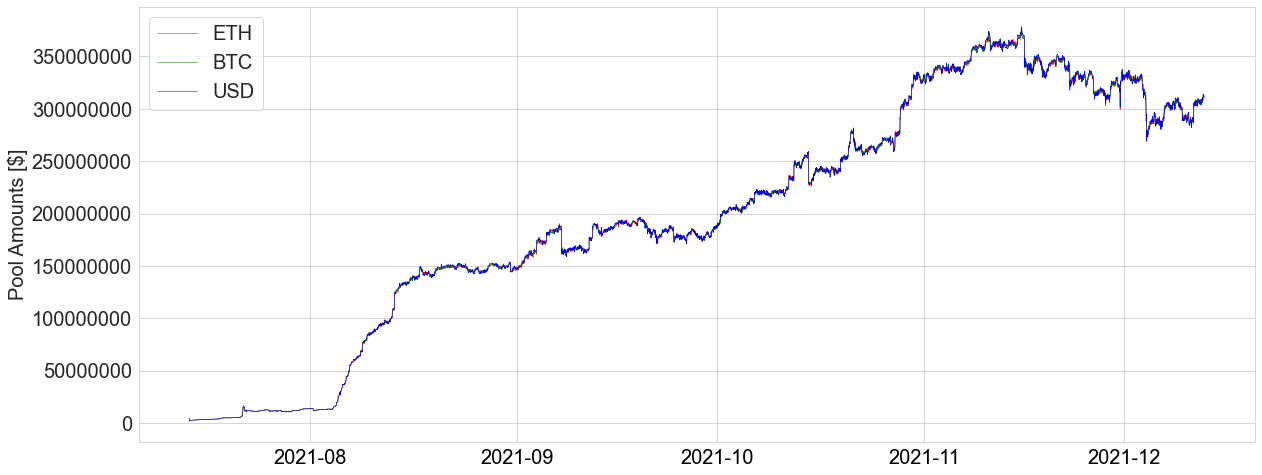

In [40]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_swaps.index,
    df_swaps.eth_balance_usd,
    '-',
    color='r',
    lw=0.5,
    label='ETH'
)

ax.plot(
    df_swaps.index,
    df_swaps.btc_balance_usd,
    '-',
    color='g',
    lw=0.5,
    label='BTC'
)

ax.plot(
    df_swaps.index,
    df_swaps.usdt_balance,
    '-',
    color='b',
    lw=0.5,
    label='USD'
)

ax.set_xlabel("")
ax.set_ylabel("Pool Amounts [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

In [41]:
df_swaps.total_sold_usd.describe()

count    1.841500e+04
mean     2.365761e+05
std      2.494438e+05
min      1.000000e+00
25%      1.106506e+05
50%      1.966216e+05
75%      3.041475e+05
max      1.712622e+07
Name: total_sold_usd, dtype: float64

Get Claimed Fees:

In [42]:
query = """
{
  claimAdminFeeEvents(first: 1000) {
    id
    blockNumber
    timestamp
    txHash
    amountClaimed
    claimDollarValue
    assetPrices{
      crv3cryptoUSD
    }
  }
}

"""

r = requests.post(api, json={'query': query})
data = dict(r.json())
claims = data['data']['claimAdminFeeEvents']
de_nested_claim_txes = []
for claim in claims:

    crv3crypto_price_usd = claim['assetPrices']['crv3cryptoUSD']
    claim_timestamp = int(claim['timestamp'])
    claim_time = datetime.datetime.fromtimestamp(claim_timestamp)

    de_nested_claim_txes.append(
        {
            'claim_time': claim_time,
            'block_number': int(claim['blockNumber']),
            'tx_hash': claim['txHash'],
            'fees_claimed_usd': float(claim['claimDollarValue']),
            'total_pool_fees_usd': 2*float(claim['claimDollarValue']),
            'amount_crv3crypto_claimed': float(claim['amountClaimed']),
            'crv3crypto_price_usd': crv3crypto_price_usd
        }
    )

df_claims = pd.DataFrame(de_nested_claim_txes)
df_claims.set_index('claim_time', inplace=True)
df_claims.sort_index(inplace=True)
df_claims

,block_number,tx_hash,fees_claimed_usd,total_pool_fees_usd,amount_crv3crypto_claimed,crv3crypto_price_usd
claim_time,,,,,,
2021-07-14 00:05:39,12821359,0xc4c0cc90e651f0efd663ab540db9f536b49214e6611e...,3186.598019,6373.196037,2.265266,1406.721027589770665732772304108913
2021-07-14 01:31:13,12821690,0xe6b809e14cafe27d566930f605e7afd7b29743f59817...,19.285466,38.570932,0.016117,1196.560181548298625403385129307026
2021-07-14 13:28:13,12824888,0xf29a0ecc660154e316656e42b357a7dc06d9465ba2be...,485.003089,970.006178,0.406128,1194.213421359944277388282567786302
2021-07-14 20:21:50,12826698,0xa6c5f88e7095e50674f6e742ae5a61dafe3261cf57d0...,338.006870,676.013740,0.278989,1211.54016780143034414613238361851
2021-07-15 08:57:56,12830058,0x23391f5e3ea17fb4d0fe7d40408226c8cf0c3887d69e...,312.898193,625.796387,0.260865,1199.464886982263970142521629246231
...,...,...,...,...,...,...
2021-12-08 01:00:16,13761569,0xe5547b35081b24afaa9a43893f264ccb1a7d6acbbecd...,876.945200,1753.890400,0.483738,1812.852110479492006846981244967129
2021-12-09 01:01:37,13767799,0x0e1847a03c19324690030be26b6e7217656f136ef776...,22760.516213,45521.032427,12.427863,1831.41022764529186849309880007792
2021-12-10 00:59:41,13774074,0xa82fe52143e08c9ea7e0bbb48c9d1c9badcf201784f4...,27243.428966,54486.857931,15.443246,1764.099938769422534358557067429761


Plots of swaps and claims:

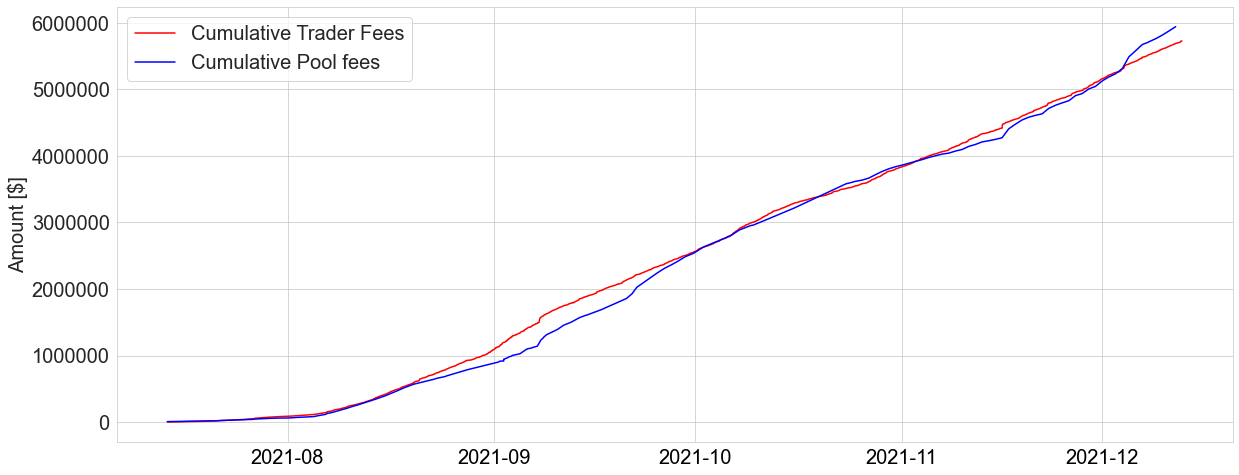

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_swaps.index,
    df_swaps.swap_fee_usd.cumsum(),
    '-',
    color='red',
    label='Cumulative Trader Fees'
)

ax.plot(
    df_claims.index,
    df_claims.total_pool_fees_usd.cumsum(),
    '-',
    color='b',
    label='Cumulative Pool fees'
)

ax.set_xlabel("")
ax.set_ylabel("Amount [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)